In [1]:
import os
import itertools
import random
from typing import Sequence

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Ensure 3D plotting is available
import torch
from pathlib import Path
from pytorch_lightning import seed_everything
from torch.nn import functional as F
import numpy as np




try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

# from nn_core.common import PROJECT_ROOT
import pickle

print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))
from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align import FeatureExtractor
# from src.zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align_hidden import Policy
from src.zeroshotrl.utils.relative import *
from src.zeroshotrl.utils.notebooks import *

import latentis

print(latentis.__version__)

# Relative stuff
from latentis.space import LatentSpace
from latentis.project import RelativeProjector
from latentis.project import relative
from latentis.transform import Centering, StandardScaling

# from latentis.transform.base import StandardScaling, Centering
# from latentis.transform.dim_matcher import ZeroPadding
# from latentis.transform.translate.aligner import MatrixAligner, Translator
# from latentis.transform.translate.functional import (
#     svd_align_state,
# )


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

from zeroshotrl.utils.relative import *
from zeroshotrl.utils.notebooks import *

/Users/antonioricciardi/projects/rl_relrepr_gymnasium/notebooks
/Users/antonioricciardi/projects/rl_relrepr_gymnasium
0.0.7


In [2]:

anchors_env_id1 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"
anchors_env_id2 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"
obs_env_id1 = "LunarLanderRGB" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" #"LunarLanderRGB"
obs_env_id2 = "LunarLanderRGB-3" # "MiniWorld-OneRoom-v0" # "CarRacing-v2" # "LunarLanderRGB"

anchors_color1 = "red" # "standard"
anchors_color2 = "white" # "standard"

color1 = "red" # "standard"
color2 = "white" # "standard"

layers_list = ['enc', 'pol']
layer_to_use = layers_list[0]

enc1_seed = 1
enc2_seed = 1

anchors_path1 = f"data/anchors/{anchors_env_id1}/rgb_ppo_transitions_{anchors_color1}_obs.pkl"
anchors_path2 = f"data/anchors/{anchors_env_id2}/rgb_ppo_transitions_{anchors_color2}_obs.pkl"
obs_path1 = f"data/anchors/{obs_env_id1}/rgb_ppo_transitions_{color1}_obs.pkl"
obs_path2 = f"data/anchors/{obs_env_id2}/rgb_ppo_transitions_{color2}_obs.pkl"


algo1 = "ppo"
algo2 = "ppo"
env_id1 = obs_env_id1# "CarRacing-v2"
env_id2 = obs_env_id2# "CarRacing-v2-bus"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc1_path = f"models/{env_id1}/rgb/{color1}/{algo1}/absolute/relu/seed_{enc1_seed}/encoder.pt"
enc2_path = f"models/{env_id2}/rgb/{color2}/{algo2}/absolute/relu/seed_{enc2_seed}/encoder.pt"
encoder1_dict = torch.load(
    enc1_path,
    map_location=device,
)
encoder2_dict = torch.load(
    enc2_path,
    map_location=device,
)

In [3]:
encoder1 = FeatureExtractor()
encoder2 = FeatureExtractor()
encoder1.load_state_dict(encoder1_dict)
encoder2.load_state_dict(encoder2_dict)

<All keys matched successfully>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder1.to(device)
encoder2.to(device)


obs_set_1 = pickle.load(Path(obs_path1).open("rb"))  # [30:2000]
obs_set_2 = pickle.load(Path(anchors_path2).open("rb"))  # [30:2000]
print("\n#####\nObs loaded\n#####\n")

anchors_set_1 = pickle.load(Path(anchors_path1).open("rb"))
anchors_set_2 = pickle.load(Path(anchors_path2).open("rb"))
anchors_set_1 = torch.tensor(np.array(anchors_set_1), dtype=torch.float32)
anchors_set_2 = torch.tensor(np.array(anchors_set_2), dtype=torch.float32)
# subset_indices = np.random.randint(0, len(obs_set_1), 5000)
obs_set_1 = obs_set_1
obs_set_2 = obs_set_2

print("Converting obs to torch tensor")
# convert the (4000, 3, 84, 84) numpy array to a torch tensor
obs_set_1 = torch.tensor(np.array(obs_set_1), dtype=torch.float32)
obs_set_2 = torch.tensor(np.array(obs_set_2), dtype=torch.float32)
print("Done converting obs to torch tensor\n#####\n")

# obs_set_1 = torch.cat([obs_set_1, obs_set_2], dim=0)  # [anch_indices
# obs_set_2 = obs_set_1

# obs_set_1 = torch.cat(obs_set_1, dim=0).cpu()  # [anch_indices]
# obs_set_2 = torch.cat(obs_set_2, dim=0).cpu()  # [anch_indices]
space1 = encoder1.forward_single(obs_set_1[:900].to(device))#.detach().cpu()
space2 = encoder2.forward_single(obs_set_2[:900].to(device))#.detach().cpu()


#####
Obs loaded
#####

Converting obs to torch tensor
Done converting obs to torch tensor
#####



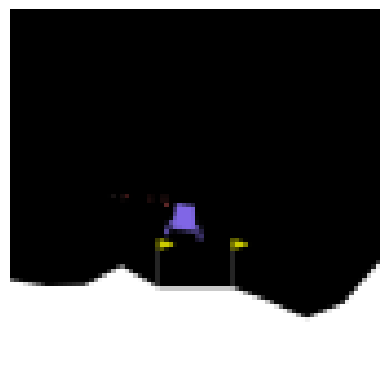

In [32]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = 610
fig, ax = plt.subplots(1, 1)
ax.imshow(anchors_set_2[i].permute(1, 2, 0))
plt.axis('off')
plt.show()

# save image to file as pdf
fig.savefig("experiments/plots/lunar_frame_{i}.pdf", bbox_inches='tight')

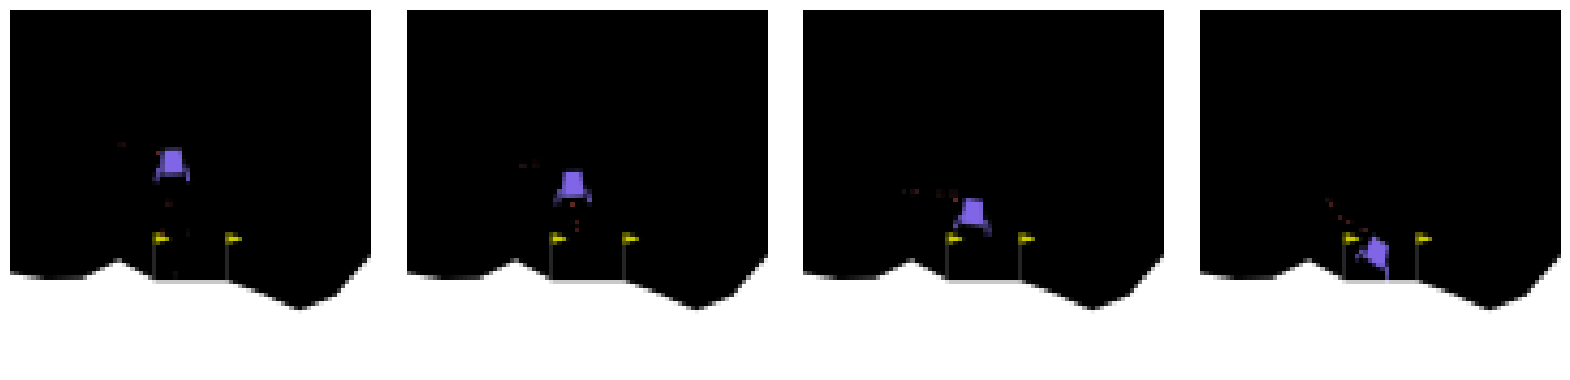

In [ ]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = [590, 600, 610, 620]
fig, ax = plt.subplots(1, len(i), figsize=(20, 5))  # Adjust figsize as needed
for j, idx in enumerate(i):
    ax[j].imshow(anchors_set_2[idx].permute(1, 2, 0))
    ax[j].axis('off')
plt.show()


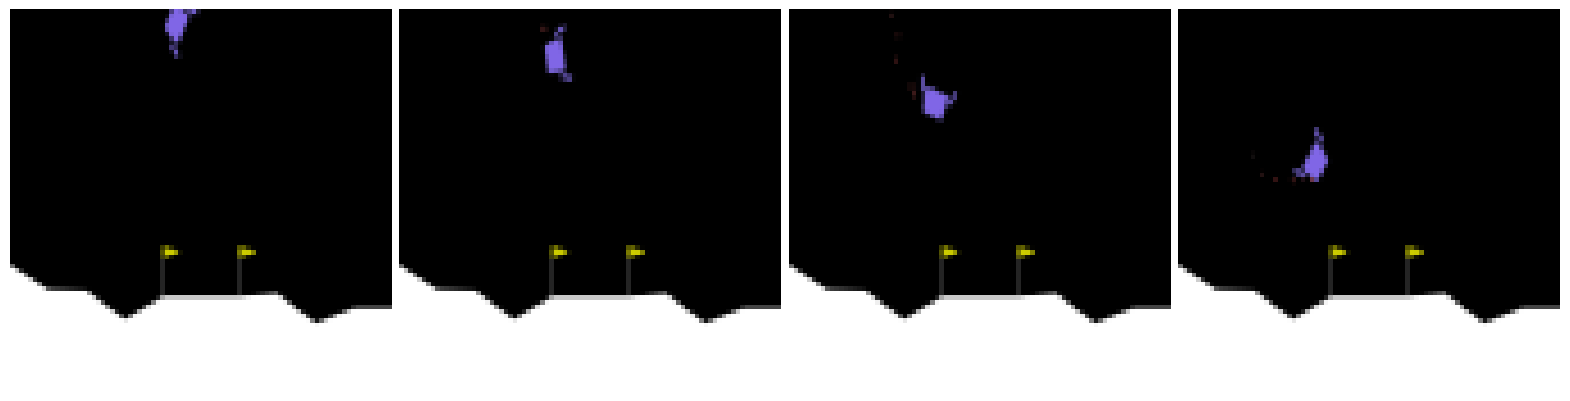

In [57]:
import matplotlib.pyplot as plt

i = [30, 40, 50, 60]
fig, ax = plt.subplots(1, len(i), figsize=(20, 5))  # Adjust figsize as needed

for j, idx in enumerate(i):
    ax[j].imshow(anchors_set_2[idx].permute(1, 2, 0))
    ax[j].axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0)  # Minimize spacing
plt.show()

# save image to file as pdf
fig.savefig("experiments/plots/lunar_frames_rand.pdf", bbox_inches='tight')